In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph

from matplotlib.patches import FancyArrowPatch, Circle, Ellipse

In [2]:
from ProcessGenerator import FeatureGenerator, SimpleProcessMaker

stages = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
probas=np.array([0.1, 0.8, 0.7, 0.5, 0.5, 0.3])
maker = SimpleProcessMaker(stages=stages, probas=probas)

gen_df = pd.DataFrame()
for idx in range(200):
    d = maker.make_process_sample(idx)
    gen_df = gen_df.append(d)
    
gen = FeatureGenerator()
num_users = 5
gen_df['user'] = ['user_' + gen.label_features(label_type='string', nb_unique_labels=num_users)[0][-1] for _ in range(len(gen_df))]
gen_df.head()

,id,stages,dt,user
0,0,F,2020-01-01,user_2
1,0,A,2020-01-04,user_2
0,1,D,2020-01-01,user_2
1,1,A,2020-01-02,user_1
2,1,F,2020-01-10,user_4


### Переводим пользователей и действия в id и создаем словари чтобы потом отрисовать

In [3]:
gen_df["user_id"] = gen_df['user']
gen_df['stage_id'] = gen_df['stages']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(gen_df.stages)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(gen_df.user)):
    usr_id[usr] = i
    id_usr[i] = usr

    
user_id = [usr_id[x] for x in gen_df['user'].values]
stage_id = [act_id[x] for x in gen_df['stages'].values]

gen_df.user_id = user_id
gen_df.stage_id = stage_id

In [4]:
gen_df.head()

,id,stages,dt,user,user_id,stage_id
0,0,F,2020-01-01,user_2,2,5
1,0,A,2020-01-04,user_2,2,0
0,1,D,2020-01-01,user_2,2,3
1,1,A,2020-01-02,user_1,1,0
2,1,F,2020-01-10,user_4,4,5


### Рисуем граф

In [5]:
def draw_network(G,pos,ax,sg=None, labels=None):

    for n in G:
        if labels:
            text = labels[n]
        else:
            text = ''
        c=Ellipse(xy=pos[n],width=0.1 + 0.005*len(str(text)), height=0.05, color='c')
        ax.add_patch(c)
                  
        G.nodes[n]['patch']=c
        
    for (u,v) in G.edges:
        n1=G.nodes[u]['patch']
        n2=G.nodes[v]['patch']
#         color='k'
#         rad = 0.3
#         lw = 1
        
        lw = G[u][v]['weight']
        rad = G[u][v]['rad']
        color = G[u][v]['color']
        
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=15,
                            lw=lw,
                            alpha=0.5,
                            color=color)

        ax.add_patch(e)
        
    for n in G:
        if labels:
            text = labels[n]
        else:
            text=''
        c=Ellipse(xy=pos[n],width=0.1 + 0.005*len(text), height=0.05, color='c')
        ax.add_patch(c)
        
        x,y=pos[n]
        ax.text(x-len(text)*0.0045, y, text, fontsize=10)
        ax.autoscale()
        
    return e

In [6]:
class Graph():
    def __init__(self, df, id_col, stage_col, user_col, time_col):
        self.df = df.sort_values(by=time_col)
        self.id_col = id_col
        self.user_col = user_col
        self.stage_col = stage_col
        self.time_col = time_col
        self.stages = self.df[self.stage_col].unique()
        self.users = self.df[self.user_col].unique()
        self.act_graph = None
        self.usr_graph = None
        
    def create_activities_graph(self):
        stages = self.df[self.stage_col].unique()
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        
        
# calculate transitions

        activity_matrix = np.zeros((len(self.stages), len(self.stages)))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from'])):
                continue
                
            x_from = int(row['from'])
            x_to = int(row[self.stage_col])
            activity_matrix[x_from, x_to] += 1            

        self.activity_matrix = activity_matrix        
        self.act_prob_matrix = self.activity_matrix.copy()
        for x in self.act_prob_matrix:
            x /= x.sum()
        
# calculate positions

        mat = self.activity_matrix.copy()
        
        for i in range(mat.shape[0]):
            mat[i,i] = -1
        nodes = []        
        nodes.append(np.argmax(mat) // mat.shape[0])        
        mat[:, nodes[0]] = -1
        
        num_main = 0
        while(True):
            
            node = np.argmax(mat[nodes[-1],:])
            if np.max(mat[nodes[-1],:]) < 2:
                if num_main == 0:
                    num_main = len(nodes)
                    
            mat[:,node] = -1
            nodes.append(node)

            if len(nodes) == mat.shape[0]:
                break                 

        pos = {}
        for i, node in enumerate(nodes[:num_main]):
            x = 0.5
            y = 1 - (i + 1) / (len(nodes[:num_main]) + 2)
            pos[node] = [x, y]

        y = 1 - (i + 2) / (len(nodes[:num_main]) + 2)
        for i, node in enumerate(nodes[num_main:]):
            x = (i + 1) / (len(nodes) - num_main + 1)
            pos[node] = [x, y]
        
        self.pos = pos
        graph = DiGraph() 
        graph.add_nodes_from(nodes)

        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values.astype(int)

        graph.add_edges_from(edges)

        self.num_main = num_main
        self.main_nodes = nodes[:num_main]
        self.act_graph = graph
        return graph
    
    def create_users_graph(self):
        users = self.df[self.user_col].unique()
        self.df['from_user'] = self.df.groupby([self.id_col])[self.user_col].shift(1)
        
        
# calculate transitions

        user_matrix = np.zeros((len(self.users), len(self.users)))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from_user'])):
                continue
                
            x_from = int(row['from_user'])
            x_to = int(row[self.user_col])
            user_matrix[x_from, x_to] += 1 

        self.user_matrix = user_matrix        
        self.usr_prob_matrix = self.user_matrix.copy()
        for x in self.usr_prob_matrix:
            x /= x.sum()
        
# calculate positions

        mat = self.user_matrix.copy()
        
        for i in range(mat.shape[0]):
            mat[i,i] = -1
        nodes = []        
        nodes.append(np.argmax(mat) // mat.shape[0])        
        mat[:, nodes[0]] = -1
        
        num_main = 0
        while(True):
            
            node = np.argmax(mat[nodes[-1],:])
            if np.max(mat[nodes[-1],:]) < 2:
                if num_main == 0:
                    num_main = len(nodes)
                    
            mat[:,node] = -1
            nodes.append(node)

            if len(nodes) == mat.shape[0]:
                break                 

        pos = {}
        for i, node in enumerate(nodes[:num_main]):
            x = 0.5
            y = 1 - (i + 1) / (len(nodes[:num_main]) + 2)
            pos[node] = [x, y]

        y = 1 - (i + 2) / (len(nodes[:num_main]) + 2)
        for i, node in enumerate(nodes[num_main:]):
            x = (i + 1) / (len(nodes) - num_main + 1)
            pos[node] = [x, y]
        
        self.pos_user = pos
        graph = DiGraph() 
        graph.add_nodes_from(nodes)

        edges = self.df.loc[:, ['from_user', self.user_col]].drop_duplicates().dropna().values.astype(int)

        graph.add_edges_from(edges)

        self.num_main_user = num_main
        self.main_nodes_user = nodes[:num_main]
        self.usr_graph = graph
        return graph
    
    def draw_activities(self, labels, prob_thresh=0.2, thickness=1, info='time'):
        
# calculate weights        
        for n1,n2 in self.act_graph.edges:
            if (self.act_prob_matrix[int(n1), int(n2)] > prob_thresh) or \
                                    (n1 in self.main_nodes and  n2 in self.main_nodes):
                self.act_graph[n1][n2]['weight'] = 1 + \
                                    thickness*self.activity_matrix[int(n1), int(n2)]/self.activity_matrix.mean()
            else:
                self.act_graph[n1][n2]['weight'] = 0

# calculate time
        if info == 'time':
                        
            act_time_matrix = np.array([pd.Timedelta(0)]*(len(self.stages)**2)).reshape(len(self.stages), 
                                                                                        len(self.stages))
            self.df['prev_act_time'] = self.df[self.time_col].shift(1)
            for (_, row) in self.df.iterrows():
                if not pd.isna(row['from']):
                    act_time_matrix[int(row['from']),row[self.stage_col]]+=row[self.time_col]-row['prev_act_time']
            for i in range(len(self.stages)):
                for j in range(len(self.stages)):
                    if self.activity_matrix[i,j] != 0:
                        act_time_matrix[i,j] /= self.activity_matrix[i,j]
                        act_time_matrix[i,j] = pd.Timedelta(act_time_matrix[i,j])
            self.act_time_matrix = act_time_matrix
            
# set radius and color        
        graph = self.act_graph
        nodes = list(graph.nodes)
        num_main = self.num_main
        num_rest = len(graph.nodes) - num_main
        for n1,n2 in graph.edges:
            graph[n1][n2]['rad'] = 0.3
            graph[n1][n2]['color'] = 'pink'
            if n1 in nodes[:num_main] and n2 in nodes[:num_main]:
                graph[n1][n2]['rad'] = 0.6
                graph[n1][n2]['color'] = 'm'
            elif n1 in nodes[:-num_rest//2] or n2 in nodes[num_main:-num_rest//2]:
                graph[n1][n2]['rad'] = -0.3
                graph[n1][n2]['color'] = 'pink'
        for i in range(num_main-1):
            graph[nodes[i]][nodes[i+1]]['rad'] = 0
            graph[nodes[i]][nodes[i+1]]['color'] = 'k'
            
# add fictional nodes
        graph.add_node('begin')
        graph.add_node('end')
        self.pos['begin'] = (0.5,1)
        self.pos['end'] = (0.5,0)
        labels['begin'] = 'begin'
        labels['end'] = 'end'
        graph.add_edge('begin', nodes[0], weight=1.5)
        graph.add_edge(nodes[num_main-1], 'end', weight=1.5)
        graph['begin'][nodes[0]]['rad'] = 0
        graph['begin'][nodes[0]]['color'] = 'k'
        graph[nodes[num_main-1]]['end']['rad'] = 0
        graph[nodes[num_main-1]]['end']['color'] = 'k'
        
# draw graph        
        plt.figure(figsize=(16,16))
        plt.title("Граф перехода активностей")
        ax=plt.gca()
        draw_network(self.act_graph,self.pos,ax, labels=labels)
        
        for i in range(num_main-1):
            if info == 'trans':
                ax.text(0.505, (self.pos[nodes[i]][1]+self.pos[nodes[i+1]][1])/2, 
                        int(self.activity_matrix[int(nodes[i]), int(nodes[i+1])]), fontsize=12, 
#                         rotation=90, horizontalalignment='center',
                        
                        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))
            elif info=='time':
                text = str(self.act_time_matrix[int(nodes[i]), int(nodes[i+1])])
                ax.text(0.52, (self.pos[nodes[i]][1]+self.pos[nodes[i+1]][1])/2 - len(text)*0.00265, 
                        text, fontsize=8, 
                        horizontalalignment='center', rotation=-90, 
                        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.35'))
        
        plt.axis('equal')
        plt.axis('off')

        plt.show()

    def draw_users(self, labels, prob_thresh=0.2, thickness=1, info='time'):
        
# calculate weights        
        for n1,n2 in self.usr_graph.edges:
            if (self.usr_prob_matrix[int(n1), int(n2)] > prob_thresh) or \
                                    (n1 in self.main_nodes_user and  n2 in self.main_nodes_user):
                self.usr_graph[n1][n2]['weight'] = 1 + \
                                    thickness*self.user_matrix[int(n1), int(n2)]/self.user_matrix.mean()
            else:
                self.usr_graph[n1][n2]['weight'] = 0

# calculate time
        if info == 'time':
                        
            usr_time_matrix = np.array([pd.Timedelta(0)]*(len(self.users)**2)).reshape(len(self.users), 
                                                                                        len(self.users))
            self.df['prev_usr_time'] = self.df[self.time_col].shift(1)
            for (_, row) in self.df.iterrows():
                if not pd.isna(row['from']):
                    usr_time_matrix[int(row['from']),row[self.user_col]]+=row[self.time_col]-row['prev_usr_time']
            for i in range(len(self.users)):
                for j in range(len(self.users)):
                    if self.user_matrix[i,j] != 0:
                        usr_time_matrix[i,j] /= self.user_matrix[i,j]
                        usr_time_matrix[i,j] = pd.Timedelta(usr_time_matrix[i,j])
            self.usr_time_matrix = usr_time_matrix
            
# set radius and color        
        graph = self.usr_graph
        nodes = list(graph.nodes)
        num_main = self.num_main_user
        num_rest = len(graph.nodes) - num_main
        for n1,n2 in graph.edges:
            graph[n1][n2]['rad'] = 0.3
            graph[n1][n2]['color'] = 'pink'
            if n1 in nodes[:num_main] and n2 in nodes[:num_main]:
                graph[n1][n2]['rad'] = 0.6
                graph[n1][n2]['color'] = 'm'
            elif n1 in nodes[:-num_rest//2] or n2 in nodes[num_main:-num_rest//2]:
                graph[n1][n2]['rad'] = -0.3
                graph[n1][n2]['color'] = 'pink'
        for i in range(num_main-1):
            graph[nodes[i]][nodes[i+1]]['rad'] = 0
            graph[nodes[i]][nodes[i+1]]['color'] = 'k'
            
# add fictional nodes
        graph.add_node('begin')
        graph.add_node('end')
        self.pos_user['begin'] = (0.5,1)
        self.pos_user['end'] = (0.5,0)
        labels['begin'] = 'begin'
        labels['end'] = 'end'
        graph.add_edge('begin', nodes[0], weight=1.5)
        graph.add_edge(nodes[num_main-1], 'end', weight=1.5)
        graph['begin'][nodes[0]]['rad'] = 0
        graph['begin'][nodes[0]]['color'] = 'k'
        graph[nodes[num_main-1]]['end']['rad'] = 0
        graph[nodes[num_main-1]]['end']['color'] = 'k'
        
# draw graph        
        plt.figure(figsize=(16,16))
        plt.title("Граф социальных связей")
        ax=plt.gca()
        draw_network(self.usr_graph,self.pos_user,ax, labels=labels)
        
        for i in range(num_main-1):
            if info == 'trans':
                ax.text(0.505, (self.pos_user[nodes[i]][1]+self.pos_user[nodes[i+1]][1])/2, 
                        int(self.user_matrix[int(nodes[i]), int(nodes[i+1])]), fontsize=12, 
#                         rotation=90, horizontalalignment='center',
                        
                        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))
            elif info=='time':
                text = str(self.usr_time_matrix[int(nodes[i]), int(nodes[i+1])])
                ax.text(0.52, (self.pos_user[nodes[i]][1]+self.pos_user[nodes[i+1]][1])/2 - len(text)*0.00265, 
                        text, fontsize=8, 
                        horizontalalignment='center', rotation=-90, 
                        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.35'))
        
        plt.axis('equal')
        plt.axis('off')

        plt.show()

In [27]:
graph.user_matrix


array([[14., 13., 10., 17., 11.],
       [13., 17., 18., 18., 19.],
       [13., 21., 12., 11., 18.],
       [14., 19., 19., 15., 10.],
       [22., 22., 15., 17., 17.]])

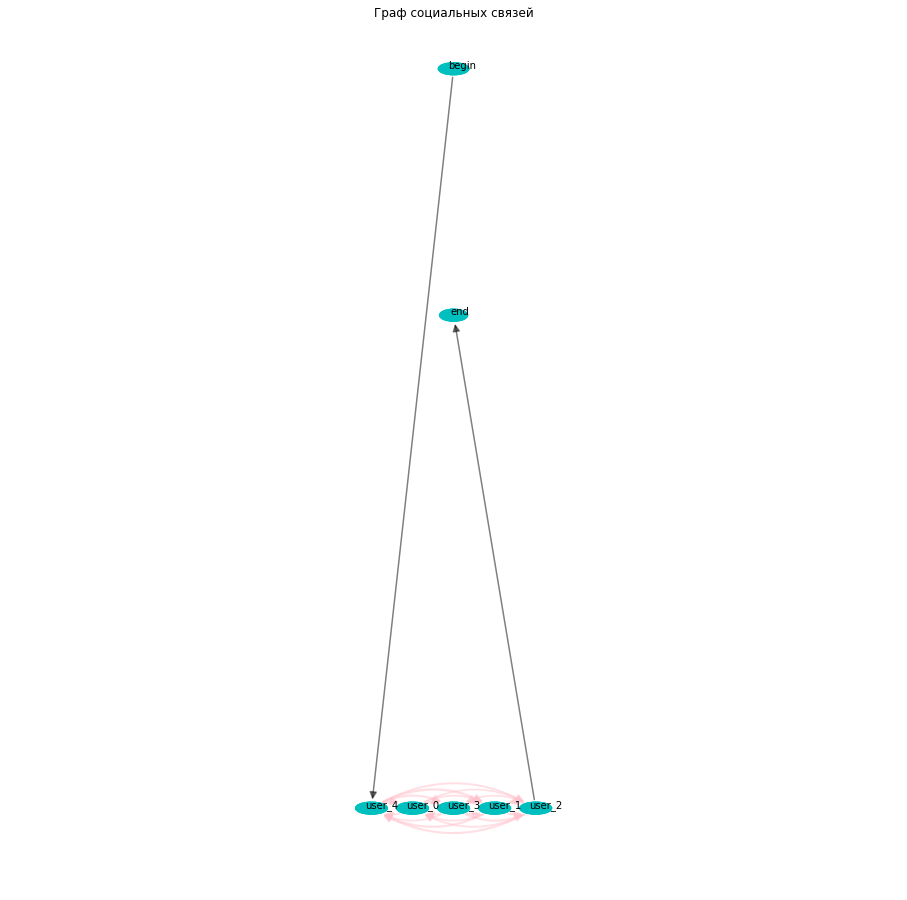

CPU times: user 1.2 s, sys: 9.6 ms, total: 1.21 s
Wall time: 1.21 s


In [31]:
%%time
graph = Graph(gen_df, 'id', 'stage_id', 'user_id', 'dt')
g = graph.create_users_graph()
graph.draw_users(labels=id_usr, thickness=1, prob_thresh=0.001,info='trans')

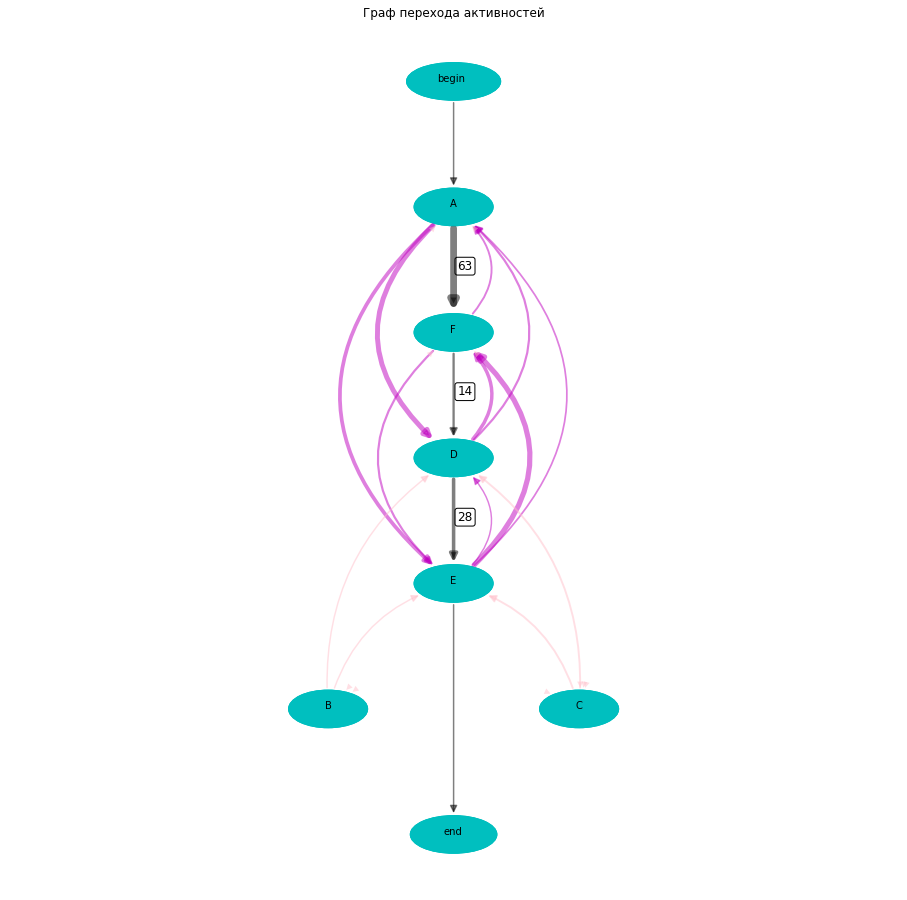

CPU times: user 1.5 s, sys: 11.8 ms, total: 1.51 s
Wall time: 1.51 s


In [8]:
%%time
graph = Graph(gen_df, 'id', 'stage_id', 'user_id', 'dt')
g = graph.create_activities_graph()
graph.draw_activities(labels=id_act, thickness=1, prob_thresh=0.25,info='trans')

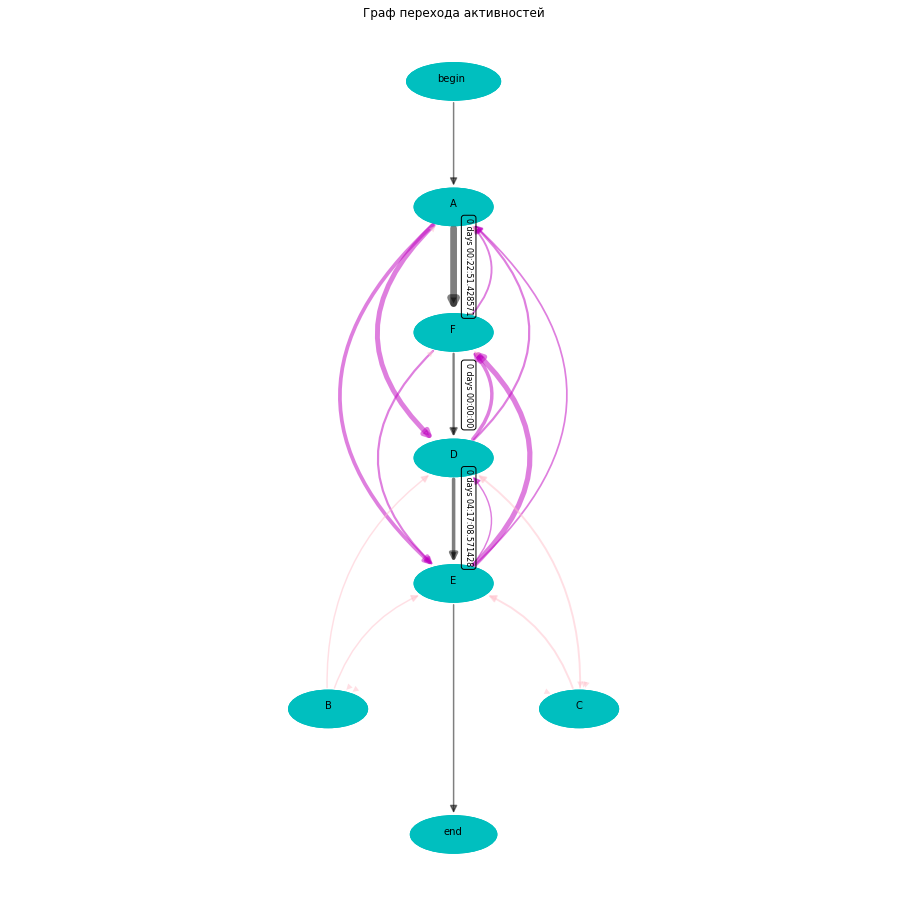

CPU times: user 1.67 s, sys: 13.7 ms, total: 1.68 s
Wall time: 1.69 s


In [9]:
%%time
graph = Graph(gen_df, 'id', 'stage_id', 'user_id', 'dt')
g = graph.create_activities_graph()
graph.draw_activities(labels=id_act, thickness=1, prob_thresh=0.25,info='time')

In [10]:
graph.act_graph.nodes

NodeView((0, 5, 3, 4, 1, 2, 'begin', 'end'))

In [11]:
id_act[3]

'D'

In [12]:
g.nodes

NodeView((0, 5, 3, 4, 1, 2, 'begin', 'end'))

In [13]:
graph.activity_matrix

array([[ 0., 10., 24., 43., 30., 63.],
       [ 4.,  0.,  1.,  5.,  5.,  2.],
       [ 8.,  0.,  0., 10., 10.,  9.],
       [13.,  1.,  5.,  0., 28., 27.],
       [ 8.,  0.,  0.,  5.,  0., 46.],
       [10.,  0.,  1., 14., 13.,  0.]])

In [14]:
graph.df[self.df.id != gen_df.id.shift(1)].stages

NameError: name 'self' is not defined

In [ ]:
l = np.array(gen_df[gen_df.id != gen_df.id.shift(1)].stages)
l[np.argmax([(l == x).sum() for x in np.unique(l)])]



In [ ]:
l = np.array(gen_df[gen_df.id != gen_df.id.shift(-1)].stages)
l[np.argmax([(l == x).sum() for x in np.unique(l)])]

